# Text document clustering based on frequent word sequences 
The following code implements the above mention research paper

Dataset used Reuters
DOI: 10.1016/j.datak.2007.08.001

The Paper tells us about a systematic approach to clustering based in fequent
word sequences

* We begin by finding frequent sequences
* Create a Generalised Suffix Tree of these sequences
* Create clusters based on cluster candidates from the tree
* Merge clusters

IMPLEMENTATION
* Prepare Data
* Preprocess Data
* Format Data
* Apply Algorithm
* Evaluation on F Score



# Preparing The Data
* importing packages
* loadind dataset
* setting parameters

Importing the neccesary libraries and packages

In [ ]:
import os
import pandas as pd
from google.colab import drive
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
nltk.download('punkt')
!pip install suffix-tree

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Load the dataset

In [ ]:
drive.mount('/content/drive')
path_dir = '/content/drive/My Drive/Dataset-TREC/Reuters-DataSets/Reuters'
files = os.listdir(path_dir)
files = sorted(files)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Setting parameters

In [ ]:
support = 0.05
threshold = 0.01
N = len(files)
corpa = 0.4
corpa = int(N*corpa)

Creating the reuters GT directory
* gt_dir is dictionary = gt_dir[category] -> files
* needed for calculation of Fscore later in
* gt_dir stores all the files in a certain category
* we can access all files in a category by passing the category as a key to gt_dir

In [ ]:
folder_gt = '/content/drive/My Drive/Dataset-TREC/Reuters-DataSets/Reuters GT'
categories = os.listdir(folder_gt)

gt_dir = {}

for cat in categories:  # category id all the classes alum, yen, baley ...
  dir_files = os.listdir(folder_gt+'/'+cat)
  gt_dir[cat] = dir_files

# Preprocess the data


We will first create two lists to store id of the text 
second for the actual text

we create a hash map to help us in mapping a file name to doc_id and vice versa

f[1][:-5] gives us the Doc Id 
f[-1] gives us complete text

To finish off we add the text to the corresponding ID in a pandas dataframe

In [ ]:
id_col = []  # All the ids in the files
text_col = []  # All the text in the files

id_to_file_map = {}  # Easy way to covert doc id into file number
file_to_id_map = {}  # Easy way to covert file number into doc id

for doc in files[:corpa]:
  f = open(path_dir+'/'+doc, 'r')
  f = f.read().split(':')
  id_col.append(int(f[1][:-5]))
  id_to_file_map[int(f[1][:-5])] = doc
  file_to_id_map[int(doc[:-4])] = int(f[1][:-5])
  text_col.append(f[-1])

corpus = {}
corpus_frame = pd.DataFrame(data=corpus)
corpus_frame['id'] = id_col
corpus_frame['text'] = text_col

corpus_frame

,id,text
0,1,Showers continued throughout the week in the ...
1,19000,Prospects for world economic growth remain ve...
2,19037,Indonesia has increased its share in a 434-bi...
3,19041,Japan's cabinet approved a plan to help finan...
4,19059,The government should cut its consumer rice p...
...,...,...
309,7775,"copper, 3.7 pct to 5.08 pct, lead .99 pct to ..."
310,7854,The Federal Trade Commission said its staff h...
311,7860,
312,7873,"A new International Natural Rubber Agreement,..."


Here we process the raw_data
* lower casing
* removal of special characters and numbers
* stemming
* tokenizing

In [ ]:
ps = PorterStemmer()

processed_text = []

raw_text = corpus_frame['text']
for sample_text in raw_text:
  sent = sample_text
  sent = sent.lower()
  sent = word_tokenize(sent)
  sent = [word for word in sent if word not in stop_words]
  sent = [clean for clean in sent if clean.isalpha()]  # removal of special characters
  sent = [ps.stem(stem) for stem in sent ]
  processed_text.append(sent)

corpus_frame['text'] = processed_text
corpus_frame

,id,text
0,1,"[shower, continu, throughout, week, bahia, coc..."
1,19000,"[prospect, world, econom, growth, remain, slug..."
2,19037,"[indonesia, increas, share, aluminium, smelter..."
3,19041,"[japan, cabinet, approv, plan, help, aluminium..."
4,19059,"[govern, cut, consum, rice, price, offici, pro..."
...,...,...
309,7775,"[copper, pct, pct, lead, pct, pct, zinc, six, ..."
310,7854,"[feder, trade, commiss, said, staff, urg, gove..."
311,7860,[]
312,7873,"[new, intern, natur, rubber, agreement, inra, ..."


# Formatting
* Creating the correct datset shape
* Encoding items based on minimum support
* Creating compact documents

The Dataset
we load just the text to 'Dataset'

In [ ]:
dataset = corpus_frame['text']

Itemsets
* we encode the items i.e terms in the dataset

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,abandon,abid,abil,abl,abolish,abroad,absolut,absorb,abund,academi,acceler,accept,access,accomplish,accord,account,accumul,accur,accus,achiev,acid,acknowledg,acquir,acquisit,acr,acreag,acrid,across,act,action,actit,activ,actual,acut,ad,adamantli,add,addit,address,adequ,...,wreck,wright,write,written,wrote,wrought,wyss,x,xuto,yaik,yamaichi,yamoussoukro,yangtz,yarn,yasuhiro,yawn,year,yearli,yen,yesterday,yet,yeutter,yield,york,yotaro,young,yugoslav,yugoslavian,zack,zair,zambia,zambian,zccm,zealand,zero,zhejiang,zheziang,zimbabw,zinc,zone
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
310,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

Minsupport
* applying the minimum support (parameter set above)

In [ ]:
from mlxtend.frequent_patterns import apriori
document_frame = pd.DataFrame(apriori(df, min_support=support, use_colnames=True, max_len=2))

document_frame['item'] = document_frame['itemsets'].apply(lambda x: list(x))  #Extracting items as lists
document_frame['length'] = document_frame['itemsets'].apply(lambda x: len(x))  #Extracting item lengths

freq_word_set = set()

for word in document_frame['item']:
  if len(word) > 1:
    freq_word_set.add(word[0])
    freq_word_set.add(word[1])
document_frame  #Frame with frequent items

,support,itemsets,item,length
0,0.050955,(accept),[accept],1
1,0.136943,(accord),[accord],1
2,0.066879,(account),[account],1
3,0.054140,(action),[action],1
4,0.162420,(ad),[ad],1
...,...,...,...,...
2771,0.070064,"(would, world)","[would, world]",2
2772,0.092357,"(world, year)","[world, year]",2
2773,0.171975,"(would, year)","[would, year]",2
2774,0.050955,"(would, yen)","[would, yen]",2


Creating Comapct Documents
* The paper introduces Compact Document
* Docs which have only the frequent sequences in them

In [ ]:
new_set = dataset.copy()

for doc in new_set:
  for word in doc:
    if word not in freq_word_set:
      doc.remove(word)

corpus_frame['text'] = new_set

Creating a dictionary of structure { id -> text }

In [ ]:
di = (pd.Series(corpus_frame.text.values,index=corpus_frame.id).to_dict())

# Applying Algorithm
* Create a GST
* Candidate cluster based on K-Mismatch
* Combining clusters
* Merging clusters based on threshold

Creating Generalise Suffix Tree (GST)
* Here we add the dictionary terms into a GST
* Using a DFS Traversal we extract the Frequent Sequences (FS)

In [ ]:
from suffix_tree import Tree

paths = {}  # paths along the tree seen during DFS

tree = Tree(di)  # GST

FS = []
for word in freq_word_set:
  for id_, path in tree.find_all([word]):  # DFS Traversal
    # print (id_, ':', str (path))
    FS.append(str(path)[:-2])
FS = list(set(FS))

FS = [word_tokenize(i) for i in FS] # All frequent sequences 

Creating the candidate superset S
* hosts all the frequent sequences

In [ ]:
S = {}  # set of all frequent sequences

for idx, seq in enumerate(FS):
  ids = []
  fsi = []
  fsi.append(seq)
  S[idx] = [seq]
  for id_, path in tree.find_all(seq):
    ids.append(id_)
  S[idx].append(ids)

We create the Candidate Clusters in the CC dict
* clustered together on K-Mismatch concept
  * | |FSj| - |FSi|| <= k 
  * all K-Mismatched cc are added to CC
* clusters may repeat hence must be merged later on

In [ ]:
CC = {}  # Clusters Extracted
cluster = 0
while len(S) > 0:
  max = list(S.keys())[0]  # Finding longest FS => FS(l)
  for i in S.keys():
    if len(S[i][0]) > len(S[max][0]):
      max = i

  longest_seq = S[max][0]
  rm = S.pop(max)  # remove from set
  cc = [] 
  cc.append(rm)  # add to cluster candidate
  for idx in list(S.keys()):
    seq = S[idx][0]
    if abs( len(seq) - len(longest_seq) ) <= 1:  # if | |FSi| - |FSj| | <= 1
      k = 0
      score = 0
      while k < len(seq):  # loop checks k mismatch at each position and assigns scores 
        if (seq[k] == longest_seq[k]):
          score += 1
        elif (len(longest_seq) != len(seq)) and (seq[k] == longest_seq[k+1]):
          score += 1
        elif k > 0 and seq[k] == longest_seq[k-1]:
          score += 1
        k += 1
      if len(seq) == score:  # if all positions matched the score must be equal to length of sequence
        cc.append(S[idx])  # add to cluster candidate
        rm = S.pop(idx)  # remove from set
        
  CC[cluster] = cc  # add all cluster candidates to one cluster 
  cluster += 1

We extract the cluster ids from the CC created above

In [ ]:
clust_ids = {}

for clust in CC.keys():  # Extracting the doc id from each cluster 
  id_set = set()
  for ent in CC[clust]:
    for ids in ent[1]:
      id_set.add(ids)
    clust_ids[clust] = id_set

Filter out clusters

In [ ]:
ss = []  # seen custers 

c_new = {}
idx = 0
for key in clust_ids.keys():  # ignores any repititions 
  if clust_ids[key] not in ss:
    c_new[idx] = clust_ids[key]
    ss.append(clust_ids[key])
    idx += 1

Merge clusters
* Here we merge the clusters if we fall with in the threshold value
* We also check to see if we have null clusters of repeated cluster
* merge the clusters

In [ ]:
seen = []
count = 0
merge = {}

for a_key in list(c_new.keys()):  # merging all clusters into one
  list_clust = set()
  for b_key in list(c_new.keys()):
    if len(c_new[a_key].intersection(c_new[b_key])) / len(c_new[a_key].union(c_new[b_key])) >= threshold:  # if excedes the threshold we merge it into one
      list_clust = list_clust.union(c_new[a_key].union(c_new[b_key]))

  if list_clust not in seen:  # check to see if any duplication 
    merge[a_key] = list_clust 
    seen.append(list_clust)

for key in list(merge.keys()):  # Removing single clusters as the have been accounted for in cluster of length > 1
  if len(merge[key]) < 2:
    merge.pop(key)

Final_cluster represents the final clusters created after merging
* we fix the index of merge 

In [ ]:
final_cluster = {}  # final clusters

seen = set()
idx = 0
for key in merge.keys():  # adjusting index for merge
  cid = []
  for ii in merge[key]:
    if ii not in seen:
      cid.append(ii)
      seen.add(ii)
  if len(cid) > 0:
    final_cluster[idx] = cid 
    idx += 1 

# Final Results of clustering

Printing out the cluster along with category 

In [ ]:
for key in final_cluster.keys():
  print('cluster ', key)
  for entry in final_cluster[key]:
    for cat in gt_dir.keys():
      t_file = id_to_file_map[entry]
      if (t_file) in gt_dir[cat]:
        print(entry,'->', cat)
  print('\n')


cluster  0
4771 -> ipi
5178 -> ipi
6158 -> ipi
6158 -> jobs
4944 -> ipi
4314 -> rice
5467 -> barley


cluster  1
1 -> cocoa
4101 -> carcass
20230 -> rubber
5640 -> barley
11273 -> alum
525 -> iron-steel
6927 -> copper
272 -> alum
5139 -> rubber
275 -> cocoa
21526 -> alum
4631 -> carcass
5148 -> iron-steel
4636 -> carcass
20005 -> cocoa
20267 -> rubber
6189 -> alum
4147 -> cocoa
11316 -> barley
21557 -> rubber
4405 -> rubber
6968 -> iron-steel
3132 -> barley
21570 -> rice
4678 -> rice
19786 -> copper
5195 -> rubber
4941 -> rubber
4431 -> copper
3324 -> barley
2389 -> carcass
4697 -> alum
20058 -> alum
19037 -> alum
19041 -> alum
3438 -> rubber
19570 -> cocoa
19061 -> yen
3957 -> alum
3445 -> rice
4215 -> iron-steel
21368 -> ipi
377 -> alum
1915 -> rice
2172 -> barley
3454 -> copper
7552 -> copper
1156 -> iron-steel
7557 -> iron-steel
7304 -> rubber
6025 -> copper
5258 -> cocoa
2186 -> copper
395 -> barley
3469 -> iron-steel
1934 -> iron-steel
2191 -> barley
5266 -> rice
6546 -> alum
680

In [ ]:
len(final_cluster)

43

# Evaluation
* 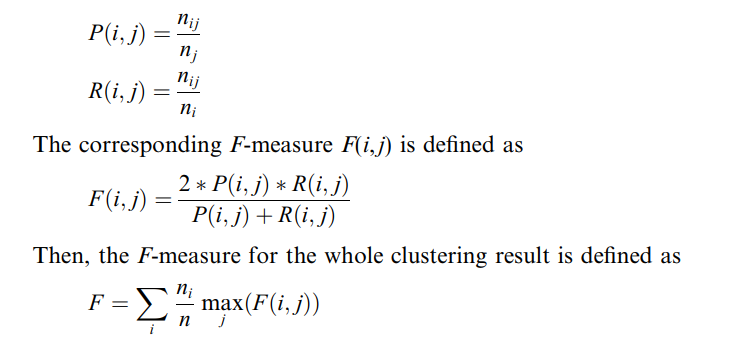

* we create ni {}
* we store all the counts of each class
* ni[class] -> count

In [ ]:
# ni = {}  # ni => counts of each class in the sample
# for cat in gt_dir.keys():
#   ni[cat] = 0
#   for key in final_cluster.keys():
#     for entry in final_cluster[key]:
#       t_file = id_to_file_map[entry]  # mapping ID to File name
#       if (t_file) in gt_dir[cat]:  # if the file belongs to class -> increment 
#         ni[cat] += 1

# print(ni)

In [ ]:
ni = {}  # ni => counts of each class in the sample
kk = list(gt_dir.keys())

for cat in kk:
  files_list = set()
  for key in final_cluster.keys():
    for entry in final_cluster[key]:
      t_file = id_to_file_map[entry]  # mapping ID to File name
      if (t_file) in gt_dir[cat]:  # if the file belongs to class -> increment 
        files_list.add(t_file)
    
  ni[cat] = len(files_list)      

print(ni)

{'ipi': 23, 'copper': 24, 'iron-steel': 25, 'carcass': 34, 'cocoa': 29, 'jobs': 25, 'yen': 19, 'rice': 29, 'gas': 16, 'rubber': 24, 'alum': 21, 'barley': 21}


* we create nj {}
* we store the counts in each cluster
* nj[index] = count


In [ ]:
nj = {}  # size of each cluster

for idx, key in enumerate(final_cluster.keys()):
  nj[idx] = len(final_cluster[key])

print(nj)

{0: 6, 1: 86, 2: 8, 3: 44, 4: 5, 5: 4, 6: 3, 7: 3, 8: 6, 9: 2, 10: 1, 11: 2, 12: 1, 13: 4, 14: 1, 15: 2, 16: 1, 17: 4, 18: 1, 19: 1, 20: 2, 21: 3, 22: 1, 23: 1, 24: 2, 25: 2, 26: 3, 27: 6, 28: 2, 29: 2, 30: 2, 31: 1, 32: 1, 33: 2, 34: 1, 35: 2, 36: 2, 37: 1, 38: 1, 39: 3, 40: 3, 41: 2, 42: 52}


* we create nij {}
* we store the counts of a class i in each cluster j
* nij[index, class] = count 
  * where i = class
  * where j = cluster number

In [ ]:
nij = {}  # count of occurance of each class in each cluster n[i, j] -> count

for cat in gt_dir.keys():
  for key in final_cluster.keys():
    nij[cat, key] = 0
    for entry in final_cluster[key]:
      t_file = id_to_file_map[entry]
      if (t_file) in gt_dir[cat]:
        nij[cat, key] += 1

nij

{('alum', 0): 0,
 ('alum', 1): 12,
 ('alum', 2): 0,
 ('alum', 3): 3,
 ('alum', 4): 0,
 ('alum', 5): 0,
 ('alum', 6): 0,
 ('alum', 7): 1,
 ('alum', 8): 0,
 ('alum', 9): 0,
 ('alum', 10): 0,
 ('alum', 11): 0,
 ('alum', 12): 0,
 ('alum', 13): 0,
 ('alum', 14): 0,
 ('alum', 15): 0,
 ('alum', 16): 0,
 ('alum', 17): 0,
 ('alum', 18): 0,
 ('alum', 19): 0,
 ('alum', 20): 0,
 ('alum', 21): 0,
 ('alum', 22): 0,
 ('alum', 23): 0,
 ('alum', 24): 0,
 ('alum', 25): 0,
 ('alum', 26): 0,
 ('alum', 27): 0,
 ('alum', 28): 0,
 ('alum', 29): 0,
 ('alum', 30): 1,
 ('alum', 31): 0,
 ('alum', 32): 0,
 ('alum', 33): 0,
 ('alum', 34): 0,
 ('alum', 35): 0,
 ('alum', 36): 0,
 ('alum', 37): 0,
 ('alum', 38): 0,
 ('alum', 39): 0,
 ('alum', 40): 0,
 ('alum', 41): 0,
 ('alum', 42): 4,
 ('barley', 0): 1,
 ('barley', 1): 15,
 ('barley', 2): 0,
 ('barley', 3): 2,
 ('barley', 4): 0,
 ('barley', 5): 0,
 ('barley', 6): 0,
 ('barley', 7): 0,
 ('barley', 8): 0,
 ('barley', 9): 1,
 ('barley', 10): 0,
 ('barley', 11): 0,
 ('b

Measuring max of F score in each class

> Indented block

> Indented block




* 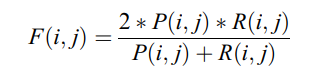

In [ ]:
f_score = 0
max_j = []  # maximum F score for a cluster 

for i in gt_dir.keys():
  f_max = 0
  for j in final_cluster.keys():
    p = nij[i,j] / nj[j]  # as instructed in the paper p(i,j) = nij/nj
    r = nij[i,j] / ni[i]  # as instructed in the paper r(i,j) = nij/ni
    if (p + r) > 0:
      f_score = (2 * p * r) / (p + r) # as instructed in the paper f(i,j) = (2*pij*rij)/pij + rij
    if f_score > f_max:
      f_max = f_score
  max_j.append(f_max)
max_j

[0.27586206896551724,
 0.21052631578947367,
 0.21621621621621617,
 0.23255813953488372,
 0.23255813953488372,
 0.20689655172413793,
 0.23999999999999996,
 0.24657534246575347,
 0.2058823529411765,
 0.21818181818181817,
 0.22429906542056074,
 0.28037383177570097]

Measured F score over each class of each cluster
 * 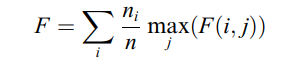

In [ ]:
F_Measure = 0

for idx, key in enumerate(gt_dir):
  score = (ni[key]/corpa) * max_j[idx]  # as instructed in the paper summation-i(ni/n * max_j(fij))
  F_Measure += score

print('F-Score = ', F_Measure)

F-Score =  0.2148590388866611


Measuring Purity

In [ ]:
max_nij = []

for j in nj.keys():
  max = 0
  for i in ni.keys():
    if nij[i, j] > max:
      max = nij[i,j]
  
  max_nij.append(max)

max_nij
sum(max_nij)/corpa

0.31210191082802546

# Results Comaprison
* Maximum F Measure = 0.974 @ corpus 40% support 5%
* Maximum Purity = 0.822 @ corpus 40% support 5%

* 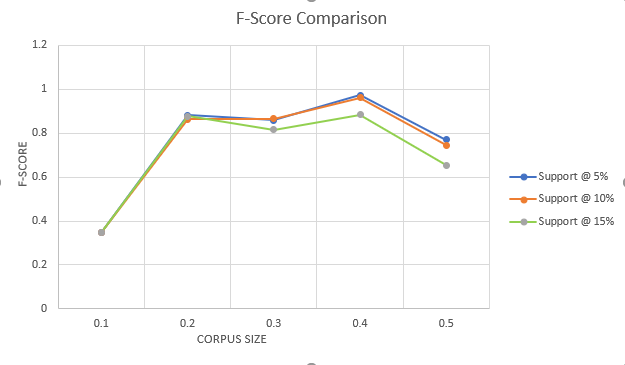


The Results at support 5%
* 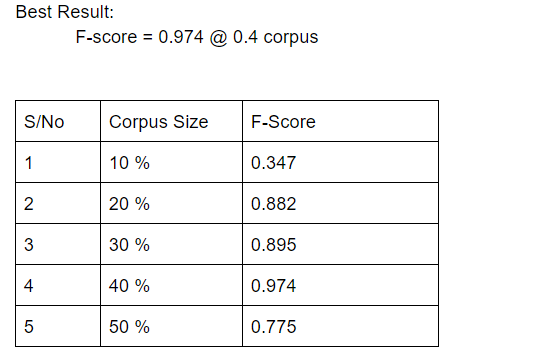

The Results at support 10% 
* 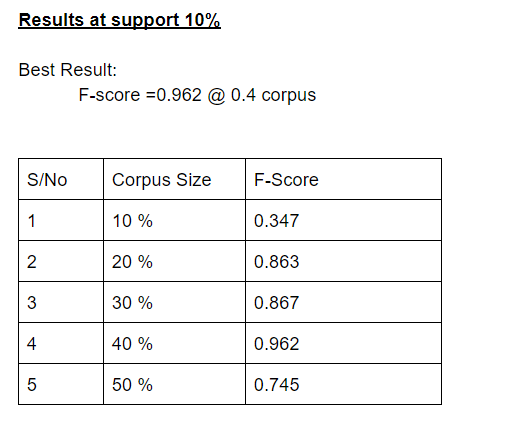

The Results at support 15%
* 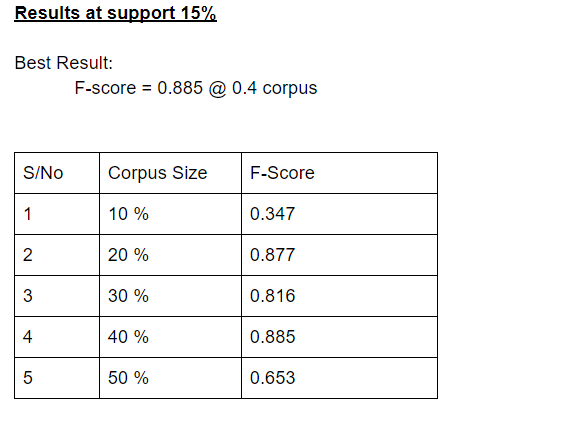